# ASP3231 Laboratory 4: Calibrated Catalogues

In this week's laboratory we going to use archival data to estimate V-band magnitudes of bright stars, create a catalogue of celestial objects using Monash C14 data and use that catalogue to produce a histogram of astronomical magnitudes.

## Prelab Questions

You are expected to read the lab notebook prior to the lab, and the Prelab Questions are designed to prompt you to consider what you have read. This will hopefully prepare you for the lab session and ultimately save time.

#### Question 1: Why do the magnitudes of stars depend on the filter they are measured in?

#### Question 2: If a star has a colour of B-V=0 why does it typically have roughly U-B=0 and V-R=0 too (for Vega-basd magnitudes)?

#### Question 3: Open AladinLite (https://aladin.u-strasbg.fr/AladinLite/), find NGC 4755 (Jewel Box) and use the SIMBAD catalogue to determine the name and V-band magnitude of a star. (Note SIMBAD magnitudes are archival and of varying quality, sometimes using CCD photometry but on occassion using photographic plate photometry).

#### Question 4: Plot a parabola in using matplotlib.

#### Question 5: Produce a histogram using matplotlib for a list that you've written yourself. Have at least ten numbers in your list. 


>1. Some stars simply emit more photons in one wavelength region compared to another - this is often reflective of the colour of the star, which is a result of Planck's law relating the temperature of a blackbody-like object to its spectral properties.

>2. These wavelengths are clustered close enough together for the approximate difference in magnitudes to about the same.

>3. Selecting NGC 4755 308, I get a V band magnitude of 13.477



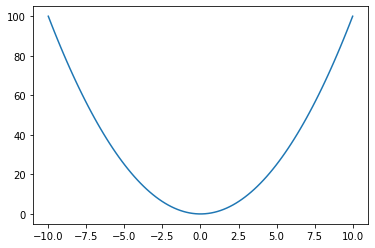

In [2]:
# question 4
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)
y = x**2

fig, ax = plt.subplots()
ax.plot(x, y)


[]

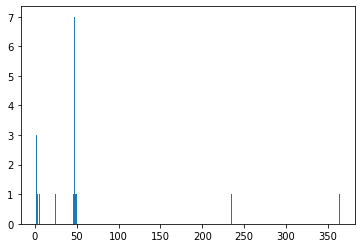

In [21]:
# Question 5
mylist = [1, 2, 5, 1, 365, 1, 2, 234, 235, 24, 3, 149, 45, 46, 47, 47, 47, 47, 47, 47, 47, 48, 49]
fig = plt.hist(mylist, bins=(max(mylist)-min(mylist)))
plt.plot()

**Task 1.** As always we import various libraries. A new one this week is astroquery - what does it do?

In [ ]:
# Import various libraries 

import numpy as np
import astropy
import photutils
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc                               

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia


**Task 2.** Rather than having many lists (arrays) of numbers to describe data, it can be useful to have a class that bundles things together. For example, the following class includes details for standard stars (stars of well known magnitude) and/or observations of such stars. 

In [ ]:
# Here's the star class, which includes a name, coordinates, exposure time, airmass, UBVRI fluxes, UBVRI magnitudes. 

class Star:
    def __init__(self):
            self.name = "Default name"                                # Object name
            self.filename = "NULL                                  "  # Image file name
            self.ra = -99.0                                           # J2000 coords ra+dec (initially given dummy values)
            self.dec = -99.0
            self.x = -99.0                                            # CCD pixel coords x-y (intially given dummy values)
            self.y = -99.0
            self.flux = [-99.0,-99.0,-99.0,-99.0,-99.0]               # UBVRI Fluxes (intially given dummy values)
            self.mag = [-99.0,-99.0,-99.0,-99.0,-99.0]                # UBRRI Magnitudes (intially given dummy values)
            self.gaiamag = [-99.0, -99.0, -99.0]                      # G_BP, G and G_RP Magnitudes (intially given dummy values)
            self.exptime = 1.0
            self.airmass = 1.0

**Task 3.** For the ASP3231 projects we are using UBVRI filters that are similar to those used by Graham (1982). Graham (1982) precisely measured UBVRI magnitudes for a series of stars in the south, and we have often used these to calibrate ASP3231 project data. The function below is designed to read the Graham (1982) text file - read the comments about that this function does.

In [ ]:
# This reads in the photometry from the Graham (1982) standard star photometry and converts to decimal degrees

def readgraham(fname):
    
  # Set the list of standards to a blank list.
    gstandards=[]

    # Open the text file defined by fname, then import the ASCII lines from the file into grahamtext
    with open(fname) as f:
        grahamtext = f.readlines()
    
    # Step through each line of grahamtext. The current line is thisline and it has index imx
    for imx, thisline in enumerate(grahamtext): 

        # Read in coordinates - each variable has specific columns, defined in the README file
        rah=float(thisline[15:17])   # Read in RA hours from the ASCII, and covert to float
        ram=float(thisline[18:20])   # Read in RA minutes from the ASCII, and covert to float
        ras=float(thisline[21:25])   # Read in RA seconds from the ASCII, and covert to float
        decd=float(thisline[27:29])  # Read in Dec degreess from the ASCII, and convert to float
        decm=float(thisline[30:32])  # Read in Dec arcminutes from the ASCII, and convert to float
        decs=float(thisline[33:35])  # Read in Dec arcseconds from the ASCII, and convert to float
        
        # Convert the coordinates to decimal degrees. 
        ra=15.0*(rah+ram/60.0+ras/3600.0)   # Convert RA to decimal degrees
        dec=decd+decm/60.0+decs/3600.0      # Convert Declination to decimal degrees
        if thisline[26]=='-':               # If the declination is negative, convert accordingly
            dec=0-dec
    
        # Read in the photometry 
        tmag=[-99.0,-99.0,-99.0,-99.0,-99.0]        # Temporary UBVRI magnitude list - initially unphysical values 
        tmag[2]=float(thisline[36:41])              # Read V magnitude from thisline and convert to float
        tmag[1]=float(thisline[50:56])+tmag[2]      # Read in B-V colour from thisline, convert to float, produce B magnitude.
        if (thisline[47]!=' '):
            tmag[0]=float(thisline[50:56])+tmag[1]  # Read in U-B colour from thisline (if available), convert to float, produce U magnitude
        tmag[3]=tmag[2]-float(thisline[57:62])      # Read in V-R colour from thisline, convert to float, prodcue R magnitude
        if (thisline[68]!=' '):
            tmag[4]=tmag[3]-float(thisline[64:69])  # Read in R-I colour from thisline, convert to float, produce I magnitude 
        
        # Create temporary tstandard, which has class star, and populate it with data from Graham (1982)
        tstandard=Star()                            # Create tstandard with class star
        tstandard.name=thisline[0:12]               # Get the name from thisline
        tstandard.ra=ra                             # Get the RA
        tstandard.dec=dec                           # Get the Declination
        tstandard.mag=tmag                          # Get the UBVRI magnitudes
        
        # Extend the list gstandards with tstandard
        gstandards.extend([tstandard])

    # The end of the indentation is where there's the end of the for-loop
    
    # The end of the function, which returns the list of Graham Standards names, coordinates and UBVRI magnitudes 
    return gstandards


**Task 4.** To actually run the function above you must run the cell below.

In [ ]:
gstandards=readgraham('Graham1982.txt')
print(len(gstandards))
print(gstandards[0].ra, gstandards[0].dec, gstandards[0].mag)

To use the Graham (1982) standards effectively we need perfectly clear nights, which are rare in Melbourne. Another option is to leverage off all sky photometry, such as the GAIA mission. The catch is GAIA uses G_BP, G and G_RP filters not the standard U, B, V, R and I filters, so we to establish the releationships between Graham (1982) photometry and Gaia photometry.

**Task 5.** The function below queries the GAIA database for photometry of Graham standards.

In [ ]:
def getgaia(gstandards):
    for obj in gstandards:
        coord = SkyCoord(ra=obj.ra, dec=obj.dec, unit=(u.degree, u.degree), frame='icrs')
        radius = u.Quantity(0.001, u.deg)
        j = Gaia.cone_search_async(coord, radius)
        r = j.get_results()
        if len(r)>0:
            obj.gaiamag[0]=r[0]['phot_bp_mean_mag']
            obj.gaiamag[1]=r[0]['phot_g_mean_mag']
            obj.gaiamag[2]=r[0]['phot_rp_mean_mag']
    return gstandards

**Task 6.** If we ran all the code below, we would query the Gaia database (which would actually take a little while) and write the results to a csv format file. Instead we are going to skip this and read the results straight from a csv file that was prepared earlier.

In [ ]:
i=0  # If i=1 then query the GAIA database
if i==1:
    gstandards=getgaia(gstandards)
    f=open("graham_gaia.csv", "w")
    f.write("Name, RA_J2000,DEC_J2000,U,B,V,R,I,G_BP,G,G_RP\n")
    for obj in gstandards:
        f.write("%s , " % obj.name)
        f.write("%9.5f , " % obj.ra)
        f.write("%9.5f , " % obj.dec)
        f.write("%6.3f , " % obj.mag[0])
        f.write("%6.3f , " % obj.mag[1])
        f.write("%6.3f , " % obj.mag[2])
        f.write("%6.3f , " % obj.mag[3])
        f.write("%6.3f , " % obj.mag[4])
        f.write("%6.3f , " % obj.gaiamag[0])
        f.write("%6.3f , " % obj.gaiamag[1])
        f.write("%6.3f \n" % obj.gaiamag[2])
    f.close()

**Task 7.** Lets load in the Graham and GAIA photometry from the existing csv file

In [ ]:
grgaia=[]
f=open("graham_gaia.csv", "r")
grahamtext = f.readlines()
for line in grahamtext:
    currentline = line.split(",")
    if currentline[0]!="Name":
        tstandard=Star()
        tstandard.name=currentline[0]
        tstandard.ra=float(currentline[1])
        tstandard.dec=float(currentline[2])
        tstandard.mag[0]=float(currentline[3])
        tstandard.mag[1]=float(currentline[4])
        tstandard.mag[2]=float(currentline[5])
        tstandard.mag[3]=float(currentline[6])
        tstandard.mag[4]=float(currentline[7])
        tstandard.gaiamag[0]=float(currentline[8])
        tstandard.gaiamag[1]=float(currentline[9])
        tstandard.gaiamag[2]=float(currentline[10])
        grgaia.extend([tstandard])
f.close()

**Task 8.** Lets now plot V minus G as a function of GAIA G_BP minus G, and fit that data. Add comments to explain what the code is doing. Describe in words what the plot is.

In [ ]:
# Plot the difference between V and G as a function of GAIA G_BP and G.

# What is px and py? What is the if statement doing?
px=[]
py=[]
for obj in grgaia:
    # Check if we have valid Graham and GAIA magnitudes and colours for the star in question.
    if obj.mag[2]>0.0 and obj.mag[2]<20.0 \
    and obj.gaiamag[0]>0.0 and obj.gaiamag[0]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.mag[2]-obj.gaiamag[1])**2<2.25 :
        px.append(obj.gaiamag[0]-obj.gaiamag[1])      # G_BP minus G
        py.append(obj.mag[2]-obj.gaiamag[1])          # V minus G
        
# What is this doing?
Vpoly=np.polyfit(px, py, 2)                           
print(Vpoly)                                          # Vpoly is a polynomial fit for the V-band

# What are plx and ply?
plx=np.arange(-0.1, 1.3, 0.1).tolist()
ply=[]
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)

# What are these lines doing?    
plt.title('V minus G as a function of colour')
plt.ylabel('Graham V - GAIA G')
plt.xlabel('GAIA G_BP - GAIA G')
plt.scatter(px, py, marker='o');
plt.plot(plx, ply, linestyle='dashed', linewidth=2);


**Task 9.** Adapt the code above to plot and fit Graham R minus GAIA G_RP as a function of GAIA G minus GAIA G_RP.

**Hint:** Don't reuse Vpoly and instead create Rpoly.

**Task 10.** A bright star in Jewel Box (HD 111990) is located at RA=193.49911961463 DEC=-60.33542302933, and has G_BP=6.85, G=6.69 and G_RP=6.43. Run the following GAIA query to confirm the photometry.

In [ ]:
gmag=[-99.0, -99.0, -99.0]
coord = SkyCoord(ra=193.49911961463, dec=-60.33542302933, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.001, u.deg)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
if len(r)>0:
    gmag[0]=r[0]['phot_bp_mean_mag']
    gmag[1]=r[0]['phot_g_mean_mag']
    gmag[2]=r[0]['phot_rp_mean_mag']
    print(gmag)

**Task 11.** Determine the V and R band magnitudes for this star. To do this use your previous results for V - G as a function of G_BP - G, and R - G_RP as a function of G - G_RP. (If the GAIA query did not run then use the values stated in the notebook.)

**Task 12.** We are now going to generate a catalogue of objects for the Jewel Box Cluster. As the stars in our Jewel Box image are reasonably well seperated, we will use the segmentation (rather than model fit approach). Run the following code and comment on what each line is doing and what the plot shows (add axis labels and a caption).

Today's image, new-image.fits, is a copy of an image taken with the C14 telescope with a world coordinate system added using astrometry.net. 

In [ ]:
scim=CCDData.read("new-image.fits", unit="adu")
med=np.median(scim.data)
scim.data=scim.data-med
mean, median, std = astropy.stats.sigma_clipped_stats(scim.data, sigma=3.0, maxiters=5)    
print('Image stats (mean, median and standard deviation):', mean,median,std)

segimage=detect_sources(scim.data, 2.00*std, 9, connectivity=4, mask=None)


**Task 13.** Comment on what is being plotted here, and how it compares to the ds9 image of Jewel Box?

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(segimage.data, cmap='gray', vmin=0, vmax=1, origin='lower')


**Task 14.** The following code writes the segmentation image to an output FITS file. Compare the segmentation image with the original image using ds9, and discuss what you see (i.e. how the images differ, and the pixel values for the segmentation map).

In [ ]:
outfile="segimage.fits"                # Set the output file name
hdu=fits.PrimaryHDU(segimage)          # Define a FITS header for this data
hdu.writeto(outfile,clobber="True")    # Write the output, and clobber (overwrite) existing files if needed. 


**Task 15.** Let's now convert the segmentation map into a catalogue of object positions using the following code.


In [ ]:
source_table=source_properties(scim.data, segimage, error=None, mask=None, background=None, filter_kernel=None, wcs=None, labels=None)
print('Source table length:\n', len(source_table))
print('First entry centroid y and x values :') # The dreaded y-x
print(source_table[0].centroid[0].value, source_table[0].centroid[1].value)


**Task 16** The following code switches the source table list of centroids (in annoying y-x format) into am x-y format list of objects positions. Adapt code from previous weeks to now run 20 pixel radius aperture photometry on this x-y list of object positions.


In [ ]:
positions=[]
for obj in source_table:
    positions.append((obj.centroid[1].value, obj.centroid[0].value))
print(positions[0:10]) # Print example values from the positions list.



**Task 17.** What flux (counts) have you measured for the bright star HD 111990 in Jewel Box that is located at RA=193.49911961463 DEC=-60.33542302933? Use https://aladin.u-strasbg.fr/AladinLite/ and ds9 to identify this star and determine its x-y coordinates, and then determine its counts in phot_table. (Remember SIMBAD magnitudes are archival and of varying quality, sometimes using CCD photometry but on occassion using photographic plate photometry).

ds9 usually displays coordinates in h\:m\:s and d\:m\:s format, but this can be changed to decimal degrees using the WCS menu.

In [ ]:
# Clue - here's a way to query a range of positions in a photometry table
# Clue - if you have a list of photometry tables, you may need to do a for loop over phot_table[0]

for obj in phot_table:
        if obj['xcenter'].value>2500 and obj['ycenter'].value<200:
            print(obj['xcenter'].value, obj['ycenter'].value)


**Task 18.** Determine the V-band magnitude of the fainter star near x=1444 y=629 using the flux of this star in ADU (from phot_table) and the estimated V-band magnitude and flux in ADU of HD 111990. This is simply using:
\begin{equation}
m_1 - m_2 = -2.5{\rm log_{10}} \left(\frac{f_1}{f_2} \right)
\end{equation}

Take care to use np.log10 and not np.log (which is natural log).

**Task 19.** Is there a way you could check your V-band magnitude above is in the right ballpark? Can you compare to other stars or use an online database? 

**Task 20.** Produce a list (array) of V-band magnitudes for all the stars in Jewel Box.

In [ ]:
maglist=[]
for obj in phot_table:
    maglist.append(1)
print(maglist)

**Task 21.** Produce a histogram of the magnitudes of the stars in Jewel Box using matplotlib. Ideally set the range so the bin width is 0.5 mag per bin.

Hint https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data

# Don't forget your conclusions